In [1]:
from glob import glob
from pprint import pprint

import io
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import Dataset, DataLoader

pd.options.display.max_rows = 200
%matplotlib inline

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


model_list = []
train_accuracy_list = []
val_accuracy_list = []
data = []
max_indices = []
index = 0
for model_path in glob('../data/results/20news/*'):
    model = model_path.split('/')[-1]
    if 'mask' in model:
        continue
    max_accuracy = 0
    for file_path in glob(model_path + '/train/*'):
        if 'overlap' in file_path and 'sentence' not in file_path:
            model_type = 'overlap'
            sequence_length, shift_length = file_path.split('/')[-1].split('.pkl')[0].split('_')[-2:]
            sequence_length = float(sequence_length)
            shift_length = float(shift_length)
            if sequence_length == 200 and shift_length == 50:
                model_type = 'baseline'
            threshold = pd.NA
        else:
            if 'sentence' in file_path:
                model_type = 'sentence-overlap'
            else:
                model_type = 'threshold'
            sequence_length, shift_length = pd.NA, pd.NA
            threshold = float(file_path.split('/')[-1].split('_')[-1].split('.pkl')[0])
        model_list.append(model)
        with open(file_path, 'rb') as file:
            contents = CPU_Unpickler(file).load()
            train_accuracy = float(max(contents['train_accuracy']))
            val_accuracy = float(max(contents['val_accuracy']))
            train_accuracy_list.append(contents['train_accuracy'])
            val_accuracy_list.append(contents['val_accuracy'])
        data.append([model, model_type, sequence_length, \
                     shift_length, threshold, train_accuracy, val_accuracy])
        
        if val_accuracy > max_accuracy:
            max_index = index
            max_accuracy = val_accuracy
        index += 1
        
    max_indices.append(index-1)
        
            
results = pd.DataFrame(data, columns=['model', 'model_type', 'sequence_length', \
                     'shift_length', 'threshold', 'train_accuracy', 'val_accuracy'])
results.sort_values(['model', 'model_type', 'sequence_length', \
                     'shift_length', 'threshold'], inplace=True)
results.reset_index(drop=True, inplace=True)
results

,model,model_type,sequence_length,shift_length,threshold,train_accuracy,val_accuracy
0,bert-base-cased,baseline,200,50,<NA>,0.930963,0.623342
1,bert-base-cased,overlap,100,50,<NA>,0.948542,0.655172
2,bert-base-cased,overlap,100,100,<NA>,0.873515,0.577365
3,bert-base-cased,overlap,150,37,<NA>,0.832564,0.569408
4,bert-base-cased,overlap,150,75,<NA>,0.934891,0.616269
5,bert-base-cased,overlap,150,150,<NA>,0.822646,0.551724
6,bert-base-cased,overlap,200,100,<NA>,0.885495,0.599469
7,bert-base-cased,overlap,200,200,<NA>,0.927723,0.572060
8,bert-base-cased,overlap,250,31,<NA>,0.921438,0.583554
9,bert-base-cased,overlap,250,62,<NA>,0.912796,0.586207


In [3]:
results.groupby(['model', 'model_type']).val_accuracy.count().unstack()

model_type,baseline,overlap,sentence-overlap,threshold
model,,,,
bert-base-cased,1,15,6,6
bert-base-uncased,1,17,6,6
bert-large-cased,1,13,6,6
bert-large-uncased,1,14,6,6


In [4]:
results.groupby('model').max()['val_accuracy']

model
bert-base-cased       0.706454
bert-base-uncased     0.739169
bert-large-cased      0.763042
bert-large-uncased    0.713528
Name: val_accuracy, dtype: float64

In [5]:
results.groupby(['model', 'model_type']).max()['val_accuracy'].unstack()

model_type,baseline,overlap,sentence-overlap,threshold
model,,,,
bert-base-cased,0.623342,0.655172,0.706454,0.694076
bert-base-uncased,0.668435,0.709107,0.739169,0.717949
bert-large-cased,0.743590,0.763042,0.632184,0.602122
bert-large-uncased,0.459770,0.573828,0.701149,0.713528


In [6]:
results[results.model == 'bert-base-uncased'].reset_index(drop=True)

,model,model_type,sequence_length,shift_length,threshold,train_accuracy,val_accuracy
0,bert-base-uncased,baseline,200,50,<NA>,0.931553,0.668435
1,bert-base-uncased,overlap,100,25,<NA>,0.934891,0.709107
2,bert-base-uncased,overlap,100,50,<NA>,0.963174,0.676393
3,bert-base-uncased,overlap,100,100,<NA>,0.920456,0.670203
4,bert-base-uncased,overlap,150,37,<NA>,0.927821,0.673740
5,bert-base-uncased,overlap,150,75,<NA>,0.907591,0.667551
6,bert-base-uncased,overlap,150,150,<NA>,0.947363,0.627763
7,bert-base-uncased,overlap,200,25,<NA>,0.945006,0.635721
8,bert-base-uncased,overlap,200,100,<NA>,0.937838,0.638373
9,bert-base-uncased,overlap,200,200,<NA>,0.937150,0.607427


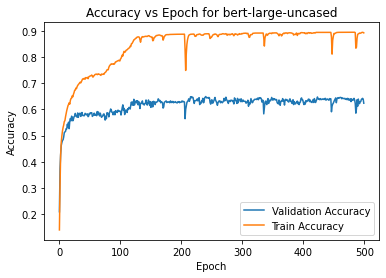

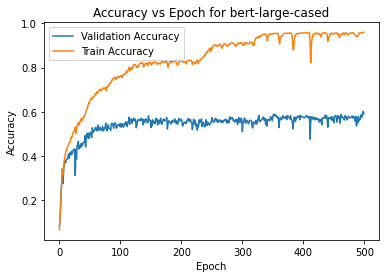

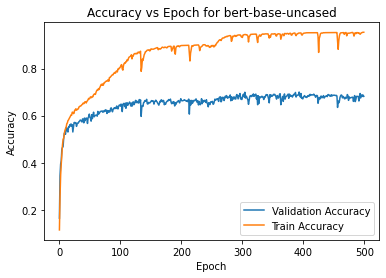

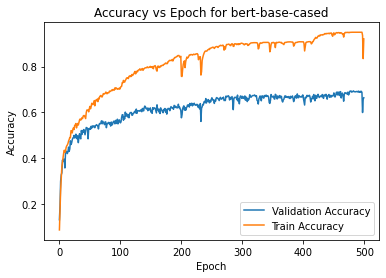

In [7]:
# fig, ax = plt.subplots(2, 2)
for index in max_indices:
    model = model_list[index]
    plt.plot(val_accuracy_list[index], label='Validation Accuracy')
    plt.plot(train_accuracy_list[index], label='Train Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epoch for ' + model)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()